# Fitting PSD-s from 22_03_23 /results/noise/noise_data_start-end.h5

In [1]:
from mcbj import *
from pca_and_ml import *
from noise import *
from IPython.display import display, Markdown
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, StrMethodFormatter
import pandas as pd
import re

import filter_traces
import plots

date = "22_03_23"
sample_rate = 50_000
# home_folder = Path(f"D:/BJ_Data/{date}")
home_folder = Path(f'//DATACENTER/BreakJunction_group/BJ_Data/{date}')

In [81]:
input_file='noise_data_start-end.h5'

In [82]:
areas_all_1 = []
areas_all_2 = []
cond_avg_all_1 = []
cond_avg_all_2 = []
traces_1 = []
traces_2 = []

psd_results_all_1 = []
psd_results_all_2 = []

fft_freqs_all_1 = []
fft_freqs_all_2 = []

pc_key='PC4'
for trace_ind in tqdm(range(0, 8000)):
    with h5py.File(home_folder.joinpath(f'results/noise/{input_file}'), 'r') as f:
        trace = re.search(r'_(\d*)', list(f[f'{pc_key}/group1'].keys())[trace_ind])[1]
        # print(trace)

        trace_pair_1=TracePair(trace, load_from=home_folder)
        # conductance_1 = f[f'{pc_key}/group1/trace_{trace}/conductance'][:]
        # piezo_1 = f[f'{pc_key}/group1/trace_{trace}/piezo'][:]
        # psd_intervals_1 = f[f'{pc_key}/group1/trace_{trace}/psd_intervals'][:]
        psd_results_1 = f[f'{pc_key}/group1/trace_{trace}/psd_results'][:]
        fft_freqs_1 = f[f'{pc_key}/group1/trace_{trace}/fft_freqs'][:]
        areas_1 = f[f'{pc_key}/group1/trace_{trace}/areas'][:]
        avg_conductance_in_win_1 = f[f'{pc_key}/group1/trace_{trace}/avg_conductance_in_win'][:]
        
        areas_all_1.append(areas_1)
        cond_avg_all_1.append(avg_conductance_in_win_1)
        traces_1.append(trace_pair_1.trace_num)
        psd_results_all_1.append(psd_results_1)
        fft_freqs_all_1.append(fft_freqs_1)
        
        trace = re.search(r'_(\d*)', list(f[f'{pc_key}/group2'].keys())[trace_ind])[1]
        # print(trace)

        trace_pair_2=TracePair(trace, load_from=home_folder)
        # conductance_2 = f[f'{pc_key}/group2/trace_{trace}/conductance'][:]
        # piezo_2 = f[f'{pc_key}/group2/trace_{trace}/piezo'][:]
        # psd_intervals_2 = f[f'{pc_key}/group2/trace_{trace}/psd_intervals'][:]
        psd_results_2 = f[f'{pc_key}/group2/trace_{trace}/psd_results'][:]
        fft_freqs_2 = f[f'{pc_key}/group2/trace_{trace}/fft_freqs'][:]
        areas_2 = f[f'{pc_key}/group2/trace_{trace}/areas'][:]
        avg_conductance_in_win_2 = f[f'{pc_key}/group2/trace_{trace}/avg_conductance_in_win'][:]
        
        areas_all_2.append(areas_2)
        cond_avg_all_2.append(avg_conductance_in_win_2)
        traces_2.append(trace_pair_2.trace_num)
        psd_results_all_2.append(psd_results_2)
        fft_freqs_all_2.append(fft_freqs_2)

  0%|          | 0/8000 [00:00<?, ?it/s]

IndexError: list index out of range

In [4]:
len(cond_avg_all_1)

1600

In [5]:
# psd_results_all_1[0][2, :]

In [6]:
# fft_freqs_1

In [7]:
def fit_func_lin(x, gamma, logbeta):
    # gamma: slope
    # logbeta: log(beta) intercept
    
    return gamma * x + logbeta

def plot_func(x, gamma, logbeta):
    # gamma: slope
    # logbeta: log(beta) intercept
    
    return 10**logbeta * x**gamma

from scipy.optimize import curve_fit

def fit_psd(freq, psd, freq_range=(2000, 5000), **kwargs):
    popt, pcov = curve_fit(fit_func_lin,
                           np.log10(freq[np.bitwise_and(freq > freq_range[0], freq < freq_range[1])]),
                           np.log10(psd[np.bitwise_and(freq > freq_range[0], freq < freq_range[1])]), **kwargs)
    perr = np.sqrt(np.diag(pcov))
    
    return popt, perr

def calc_area_from_fit(fft_freqs: np.ndarray, freq_range: Tuple[float, float], gamma: float, beta: float):
    
    low_freq = fft_freqs[fft_freqs > freq_range[0]][0]
    high_freq = fft_freqs[fft_freqs < freq_range[1]][-1]
    
    return beta/(1+gamma) * (high_freq**(1+gamma) - low_freq**(1+gamma))

In [8]:
# psd_results_all_1[3]

In [9]:
psd_fit_data_1 = []
psd_fit_data_2 = []

for which_trace in tqdm(range(len(cond_avg_all_1))):
    for i, ind in enumerate(np.where(cond_avg_all_1[which_trace] > 1e-5)[0]):
        (gamma, logbeta), (dgamma, dlogbeta) = fit_psd(fft_freqs_1, psd_results_all_1[which_trace][ind, :], freq_range=(1000, 10000))
        numeric_area = areas_all_1[which_trace][ind]
        analitic_area = calc_area_from_fit(fft_freqs_1, freq_range=(2000, 5000), gamma=gamma, beta=10**logbeta)
        psd_fit_data_1.append([cond_avg_all_1[which_trace][ind], gamma, dgamma, logbeta, dlogbeta, numeric_area, analitic_area])
        
for which_trace in tqdm(range(len(cond_avg_all_2))):
    for i, ind in enumerate(np.where(cond_avg_all_2[which_trace] > 1e-5)[0]):
        (gamma, logbeta), (dgamma, dlogbeta) = fit_psd(fft_freqs_2, psd_results_all_2[which_trace][ind, :], freq_range=(1000, 10000))
        numeric_area = areas_all_2[which_trace][ind]
        analitic_area = calc_area_from_fit(fft_freqs_2, freq_range=(2000, 5000), gamma=gamma, beta=10**logbeta)
        psd_fit_data_2.append([cond_avg_all_2[which_trace][ind], gamma, dgamma, logbeta, dlogbeta, numeric_area, analitic_area])

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

In [10]:
psd_fit_data_1 = np.array(psd_fit_data_1)
psd_fit_data_2 = np.array(psd_fit_data_2)

In [11]:
psd_fit_data_1[:3, :]

array([[ 2.78693129e-04, -1.37122612e+00,  3.09221141e-01,
        -8.20956025e+00,  1.14191878e+00,  3.98215637e-10,
         2.53105326e-10],
       [ 2.37972563e-04, -9.15662422e-01,  2.80351393e-01,
        -1.05898499e+01,  1.03530607e+00,  7.28183147e-11,
         4.17472693e-11],
       [ 2.14001484e-04, -1.63711085e-01,  2.51739561e-01,
        -1.28937771e+01,  9.29645781e-01,  1.63270912e-10,
         9.22057721e-11]])

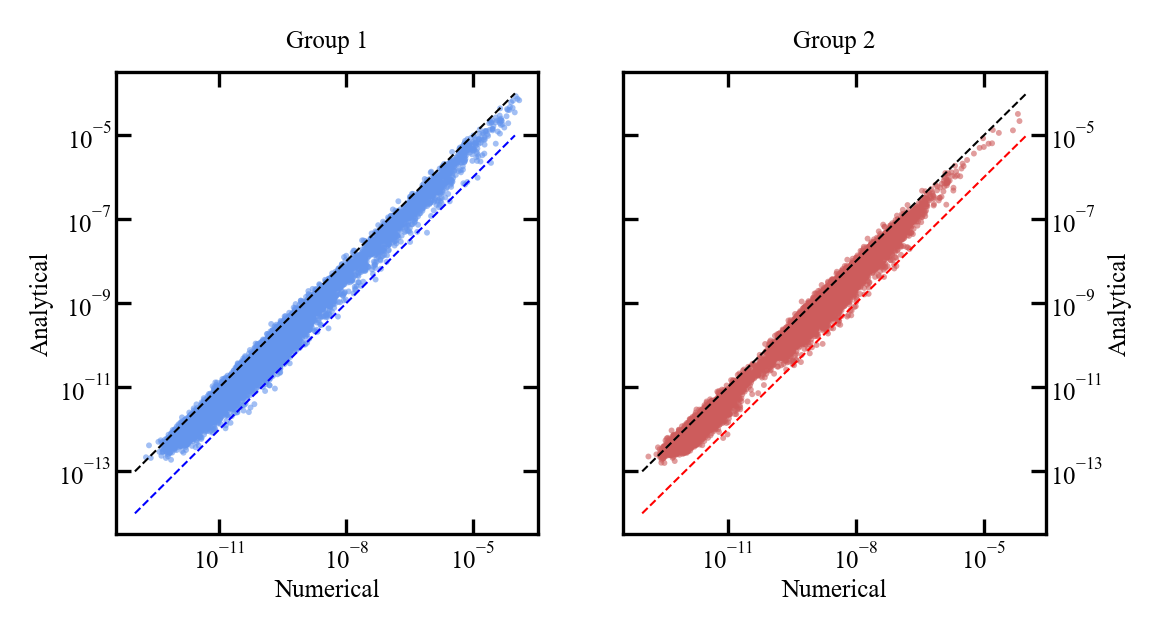

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(4, 2), dpi=300)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.scatter(psd_fit_data_1[:, -2], psd_fit_data_1[:, -1], edgecolor='None', alpha=0.6, s=2, c='cornflowerblue')
ax1.plot(np.logspace(-13, -4, base=10), np.logspace(-13, -4, base=10), ls='--', c='k', lw=0.5)
ax1.plot(np.logspace(-13, -4, base=10), np.logspace(-13, -4, base=10)/10, ls='--', c='b', lw=0.5)

ax1.set_xlabel('Numerical')
ax1.set_ylabel('Analytical')

ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.scatter(psd_fit_data_2[:, -2], psd_fit_data_2[:, -1], edgecolor='None', alpha=0.6, s=2, c='indianred')
ax2.plot(np.logspace(-13, -4, base=10), np.logspace(-13, -4, base=10), ls='--', c='k', lw=0.5)
ax2.plot(np.logspace(-13, -4, base=10), np.logspace(-13, -4, base=10)/10, ls='--', c='r', lw=0.5)

ax2.set_xlabel('Numerical')
ax2.set_ylabel('Analytical')
ax1.set_title('Group 1', fontsize=6)
ax2.set_title('Group 2', fontsize=6)

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')

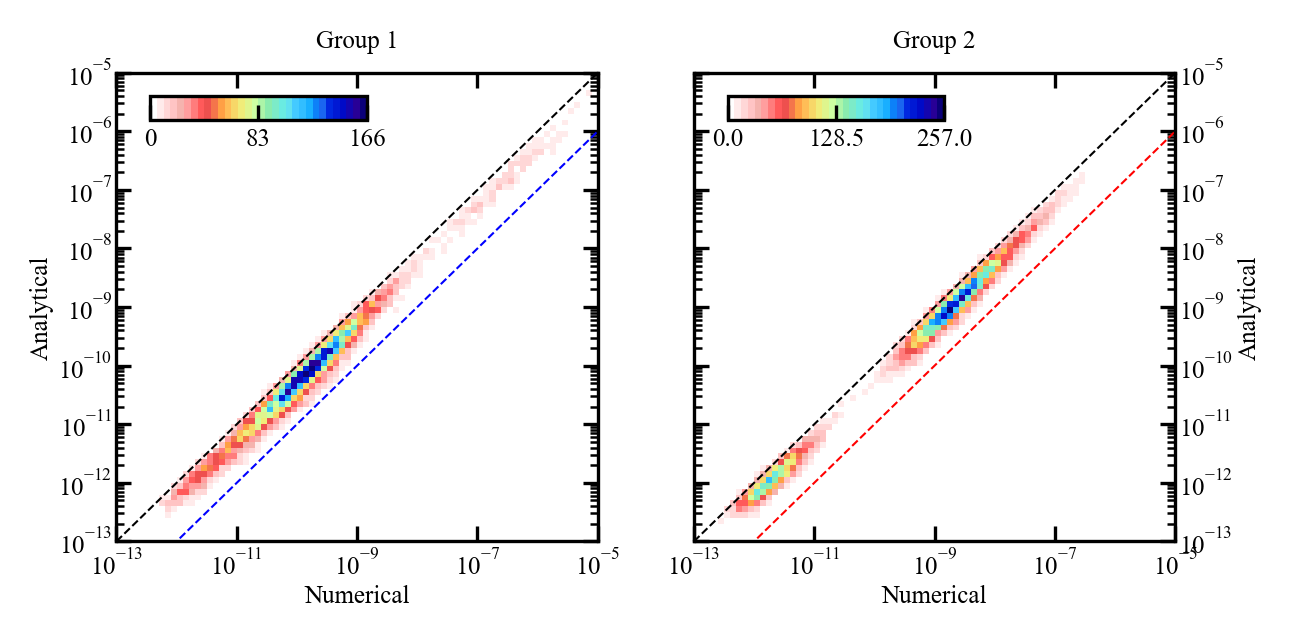

In [13]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

x_mesh, y_mesh, area_hist_1 = utils.calc_hist_2d_single(x=psd_fit_data_1[:, -2], y=psd_fit_data_1[:, -1],
                                                        xrange=(1e-13, 1e-5), log_scale_x=True,
                                                        yrange=(1e-13, 1e-5), log_scale_y=True,
                                                        num_bins=(10, 10),
                                                        bin_mode_x='decade',
                                                        bin_mode_y='decade')

x_mesh, y_mesh, area_hist_2 = utils.calc_hist_2d_single(x=psd_fit_data_2[:, -2], y=psd_fit_data_2[:, -1],
                                                        xrange=(1e-13, 1e-5), log_scale_x=True,
                                                        yrange=(1e-13, 1e-5), log_scale_y=True,
                                                        num_bins=(10, 10),
                                                        bin_mode_x='decade',
                                                        bin_mode_y='decade')

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(4, 2), dpi=300)

fig.tight_layout()
ax1.set_xscale('log')
ax1.set_yscale('log')
# ax1.scatter(psd_fit_data_1[:, -2], psd_fit_data_1[:, -1], edgecolor='None', alpha=0.6, s=2, c='cornflowerblue')
im1 = ax1.pcolormesh(x_mesh, y_mesh, area_hist_1, cmap=utils.cmap_geo32)
ax1.plot(np.logspace(-13, -5, base=10), np.logspace(-13, -5, base=10), ls='--', c='k', lw=0.5)
ax1.plot(np.logspace(-13, -5, base=10), np.logspace(-13, -5, base=10)/10, ls='--', c='blue', lw=0.5)
cbaxes_1 = ax1.inset_axes([0.07, 0.9, 0.45, 0.05])
plt.colorbar(im1, cax=cbaxes_1, ticks=np.linspace(0, max(area_hist_1.flatten()), 3), orientation='horizontal')

ax1.set_xlabel('Numerical')
ax1.set_ylabel('Analytical')

ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.plot(np.logspace(-13, -5, base=10), np.logspace(-13, -5, base=10), ls='--', c='k', lw=0.5)
ax2.plot(np.logspace(-13, -5, base=10), np.logspace(-13, -5, base=10)/10, ls='--', c='r', lw=0.5)
# ax2.scatter(psd_fit_data_2[:, -2], psd_fit_data_2[:, -1], edgecolor='None', alpha=0.6, s=2, c='indianred')
im2 = ax2.pcolormesh(x_mesh, y_mesh, area_hist_2, cmap=utils.cmap_geo32)

cbaxes_2 = ax2.inset_axes([0.07, 0.9, 0.45, 0.05])
plt.colorbar(im2, cax=cbaxes_2, ticks=np.linspace(0, max(area_hist_2.flatten()), 3), orientation='horizontal')

ax2.set_xlabel('Numerical')
ax2.set_ylabel('Analytical')
ax1.set_title('Group 1', fontsize=6)
ax2.set_title('Group 2', fontsize=6)

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')

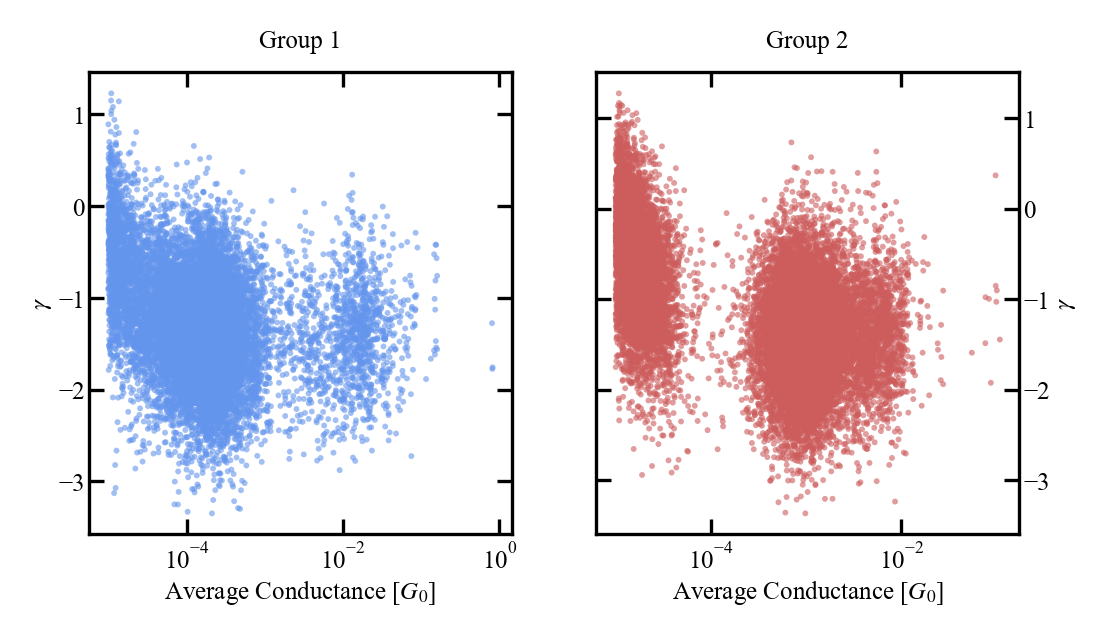

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(4, 2), dpi=300)
ax1.set_xscale('log')
# ax1.set_yscale('log')
ax1.scatter(psd_fit_data_1[:, 0], psd_fit_data_1[:, 1], edgecolor='None', alpha=0.6, s=2, c='cornflowerblue')

ax1.set_xlabel(r'Average Conductance [$G_{0}$]')
ax1.set_ylabel(r'$\gamma$')

ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')

ax2.set_xscale('log')
# ax2.set_yscale('log')
ax2.scatter(psd_fit_data_2[:, 0], psd_fit_data_2[:, 1], edgecolor='None', alpha=0.6, s=2, c='indianred')

ax2.set_xlabel(r'Average Conductance [$G_{0}$]')
ax2.set_ylabel(r'$\gamma$')
ax1.set_title('Group 1', fontsize=6)
ax2.set_title('Group 2', fontsize=6)

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')

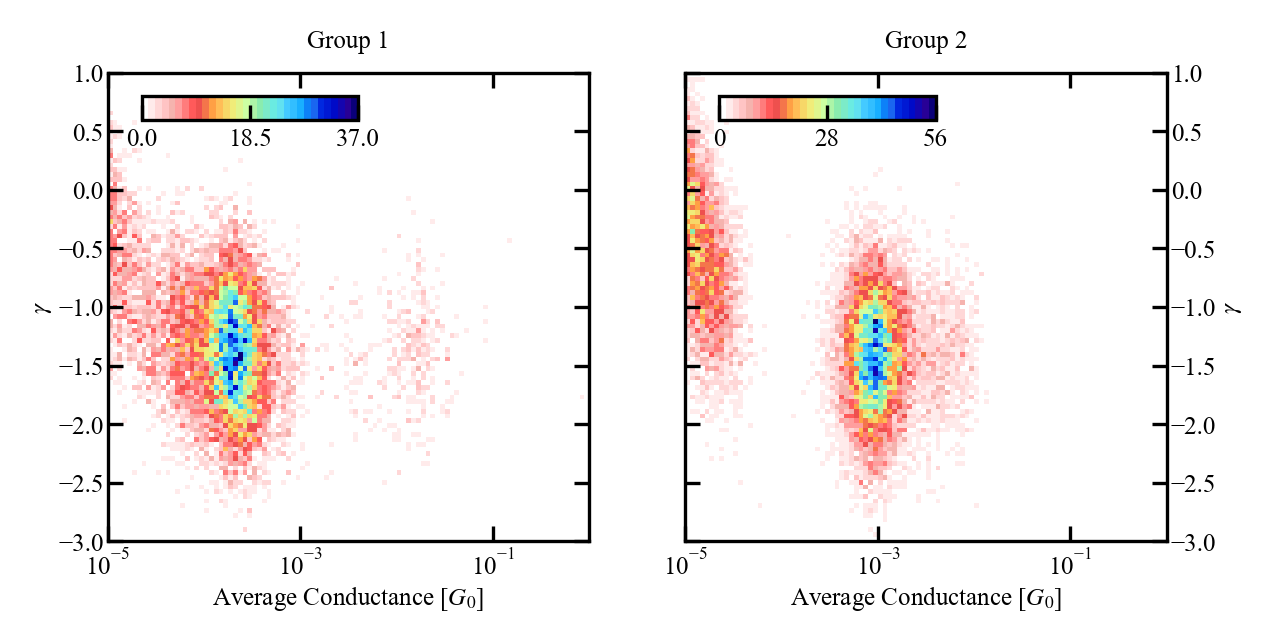

In [70]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

x_mesh, y_mesh, area_hist_1 = utils.calc_hist_2d_single(x=psd_fit_data_1[:, 0], y=psd_fit_data_1[:, 1],
                                                        xrange=(1e-5, 1), log_scale_x=True,
                                                        yrange=(-3, 1), log_scale_y=False,
                                                        num_bins=(20, 100),
                                                        bin_mode_x='decade')

x_mesh, y_mesh, area_hist_2 = utils.calc_hist_2d_single(x=psd_fit_data_2[:, 0], y=psd_fit_data_2[:, 1],
                                                        xrange=(1e-5, 1), log_scale_x=True,
                                                        yrange=(-3, 1), log_scale_y=False,
                                                        num_bins=(20, 100),
                                                        bin_mode_x='decade')

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(4, 2), dpi=300)

fig.tight_layout()
ax1.set_xscale('log')
# ax1.set_yscale('log')
# ax1.scatter(psd_fit_data_1[:, -2], psd_fit_data_1[:, -1], edgecolor='None', alpha=0.6, s=2, c='cornflowerblue')
im1 = ax1.pcolormesh(x_mesh, y_mesh, area_hist_1, cmap=utils.cmap_geo32)
# ax1.plot(np.logspace(-5, 0, base=10), np.logspace(-5, 0, base=10), ls='--', c='k', lw=0.5)
# ax1.plot(np.logspace(-5, -0, base=10), np.logspace(-5, 0, base=10)/10, ls='--', c='blue', lw=0.5)
cbaxes_1 = ax1.inset_axes([0.07, 0.9, 0.45, 0.05])
plt.colorbar(im1, cax=cbaxes_1, ticks=np.linspace(0, max(area_hist_1.flatten()), 3), orientation='horizontal')

ax1.set_xlabel(r'Average Conductance [$G_0$]')
ax1.set_ylabel(r'$\gamma$')

ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')

ax2.set_xscale('log')
# ax2.set_yscale('log')
# ax2.plot(np.logspace(-13, -5, base=10), np.logspace(-13, -5, base=10), ls='--', c='k', lw=0.5)
# ax2.plot(np.logspace(-13, -5, base=10), np.logspace(-13, -5, base=10)/10, ls='--', c='r', lw=0.5)
# ax2.scatter(psd_fit_data_2[:, -2], psd_fit_data_2[:, -1], edgecolor='None', alpha=0.6, s=2, c='indianred')
im2 = ax2.pcolormesh(x_mesh, y_mesh, area_hist_2, cmap=utils.cmap_geo32)

cbaxes_2 = ax2.inset_axes([0.07, 0.9, 0.45, 0.05])
plt.colorbar(im2, cax=cbaxes_2, ticks=np.linspace(0, max(area_hist_2.flatten()), 3), orientation='horizontal')

ax2.set_xlabel(r'Average Conductance [$G_0$]')
ax2.set_ylabel(r'$\gamma$')
ax1.set_title('Group 1', fontsize=6)
ax2.set_title('Group 2', fontsize=6)

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')

In [60]:
# psds_in_bins_1

In [61]:
# x_mesh[0]

In [62]:
psds_in_bins_1 = {}
psds_in_bins_2 = {}

for which_trace in tqdm(range(len(cond_avg_all_1))):
    for i, ind in enumerate(np.where(cond_avg_all_1[which_trace] > 1e-5)[0]):
        bin_low_lim = np.where(x_mesh[0] < cond_avg_all_1[which_trace][ind])[0][-1]  # bin_high_lim = bin_low_lim + 1
        if bin_low_lim in psds_in_bins_1.keys():
            psds_in_bins_1[bin_low_lim].append(psd_results_all_1[which_trace][ind, :])
        else:
            psds_in_bins_1[bin_low_lim] = [psd_results_all_1[which_trace][ind, :]]
        
for which_trace in tqdm(range(len(cond_avg_all_2))):
    for i, ind in enumerate(np.where(cond_avg_all_2[which_trace] > 1e-5)[0]):
        bin_low_lim = np.where(x_mesh[0] < cond_avg_all_2[which_trace][ind])[0][-1]  # bin_high_lim = bin_low_lim + 1
        if bin_low_lim in psds_in_bins_2.keys():
            psds_in_bins_2[bin_low_lim].append(psd_results_all_2[which_trace][ind, :])
        else:
            psds_in_bins_2[bin_low_lim] = [psd_results_all_2[which_trace][ind, :]]
            # print(psd_results_all_2[which_trace][ind, :].shape)
            
# x_mesh[0].shape

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

In [63]:
psds_in_bins_1.keys()

dict_keys([28, 27, 26, 5, 1, 0, 22, 15, 14, 12, 11, 49, 50, 51, 52, 32, 31, 30, 29, 25, 24, 38, 37, 21, 20, 19, 36, 35, 23, 60, 64, 62, 18, 13, 9, 10, 33, 16, 6, 4, 3, 65, 66, 63, 7, 2, 8, 17, 34, 59, 58, 57, 56, 55, 54, 53, 43, 39, 44, 45, 40, 61, 46, 48, 41, 68, 70, 69, 67, 47, 78, 77, 76, 74, 73, 72, 71, 42, 75, 79, 83, 82, 81, 84, 98])

In [64]:
mean_psds_in_bins_1 = {}
mean_psds_in_bins_2 = {}

for psd_key in psds_in_bins_1.keys():
    psds_in_bins_1[psd_key] = np.array(psds_in_bins_1[psd_key])
    mean_psds_in_bins_1[psd_key] = np.mean(psds_in_bins_1[psd_key], axis=0)
    # print(list(map(lambda x: x.shape, psds_in_bins[psd_key])))
    
for psd_key in psds_in_bins_2.keys():
    psds_in_bins_2[psd_key] = np.array(psds_in_bins_2[psd_key])
    mean_psds_in_bins_2[psd_key] = np.mean(psds_in_bins_2[psd_key], axis=0)
    # print(list(map(lambda x: x.shape, psds_in_bins[psd_key])))

In [71]:
sorted_keys_1 = np.array(list(psds_in_bins_1.keys()))
sorted_keys_1.sort()
sorted_keys_1[np.bitwise_and(sorted_keys_1>=17, sorted_keys_1<37)]

sorted_keys_2 = np.array(list(psds_in_bins_2.keys()))
sorted_keys_2.sort()
sorted_keys_2[np.bitwise_and(sorted_keys_2>=29, sorted_keys_2<49)]

array([29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
       46, 47, 48], dtype=int64)

In [72]:
# sorted_keys_1

In [67]:
# mean_psds_in_bins_1

In [68]:
gamma_mean_1 = []
gamma_mean_2 = []
cond_val_1 = []
cond_val_2 = []
for i, mean_key in enumerate(sorted_keys_1):
    # (gamma, logbeta), (dgamma, dlogbeta) = fit_psd(fft_freqs_1, mean_psds_in_bins_1[mean_key], freq_range=(1000, 10000))
    # gamma_mean_1.append([gamma, dgamma])
    cond_val_1.append((x_mesh[0][mean_key] + x_mesh[0][mean_key+1])/2)
    
    (gamma, logbeta), (dgamma, dlogbeta) = fit_psd(fft_freqs_1, mean_psds_in_bins_1[mean_key]/cond_val_1[-1], freq_range=(1000, 10000))
    gamma_mean_1.append([gamma, dgamma])
    
for i, mean_key in enumerate(sorted_keys_2):
    # (gamma, logbeta), (dgamma, dlogbeta) = fit_psd(fft_freqs_2, mean_psds_in_bins_2[mean_key], freq_range=(1000, 10000))
    # gamma_mean_2.append([gamma, dgamma])
    cond_val_2.append((x_mesh[0][mean_key] + x_mesh[0][mean_key+1])/2)
    (gamma, logbeta), (dgamma, dlogbeta) = fit_psd(fft_freqs_2, mean_psds_in_bins_2[mean_key]/cond_val_2[-1], freq_range=(1000, 10000))
    gamma_mean_2.append([gamma, dgamma])
    
gamma_mean_1 = np.array(gamma_mean_1)
gamma_mean_2 = np.array(gamma_mean_2)

Text(0.5, 0, 'Frequency [Hz]')

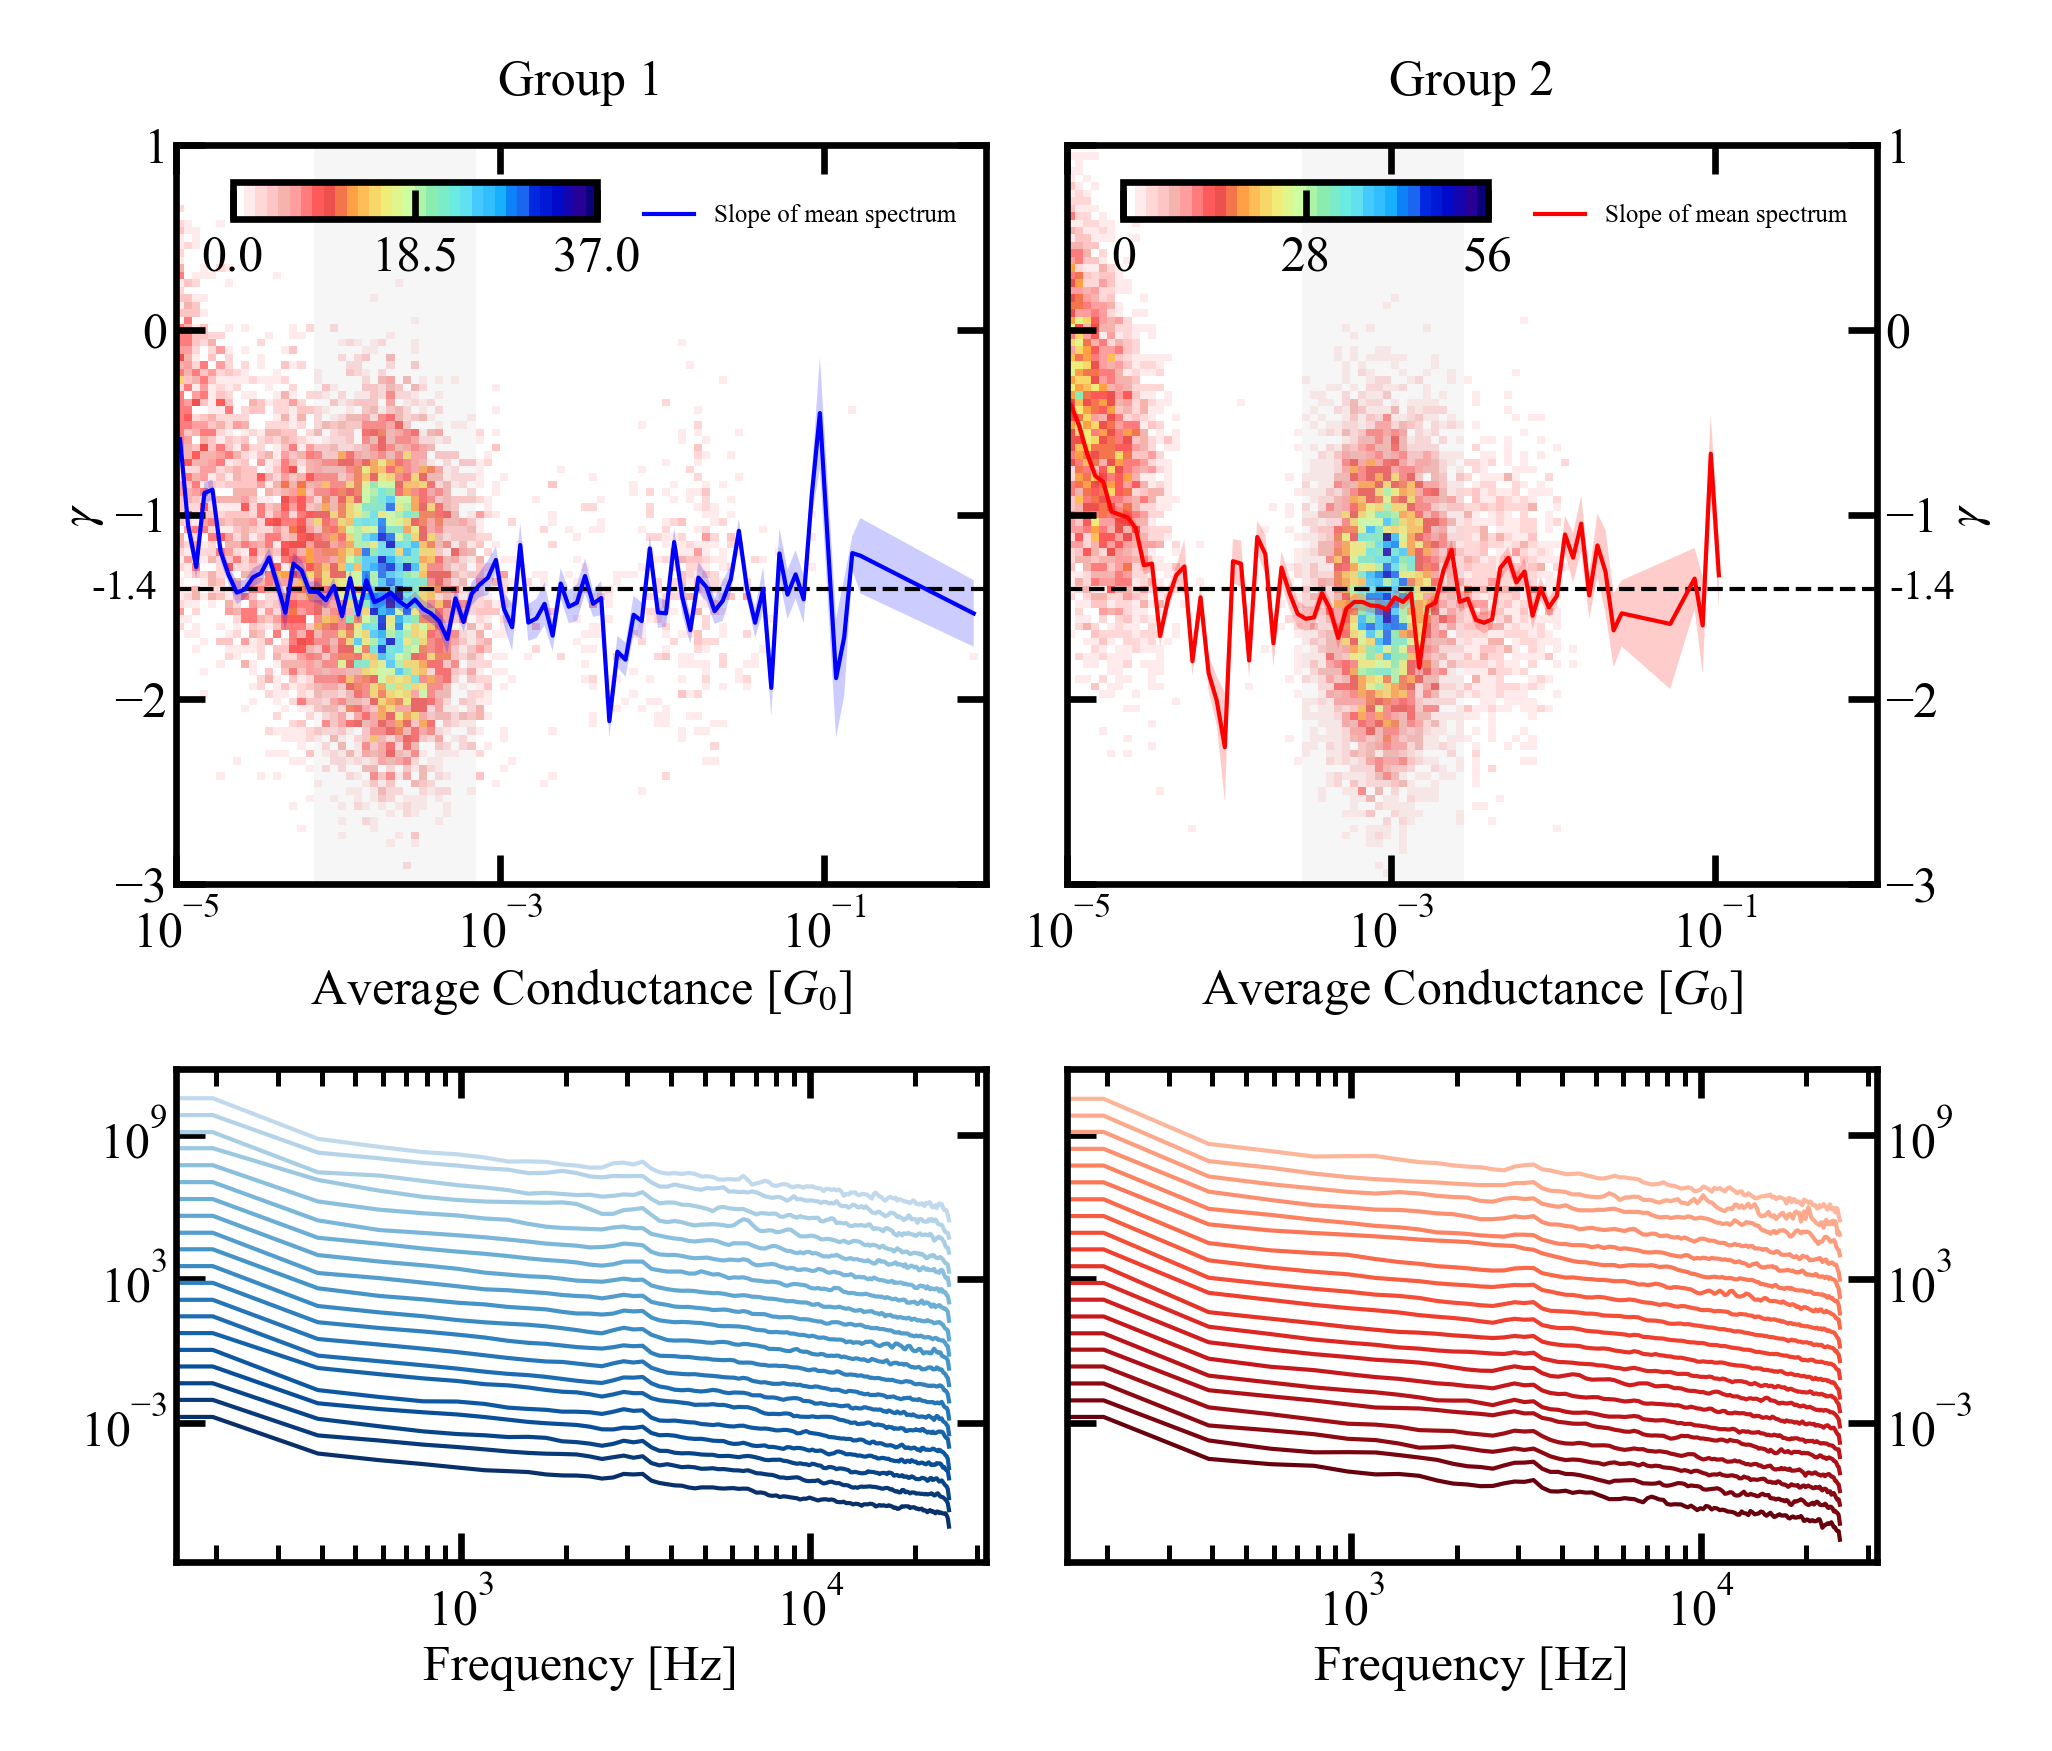

In [69]:
x_mesh, y_mesh, gamma_hist_1 = utils.calc_hist_2d_single(x=psd_fit_data_1[:, 0], y=psd_fit_data_1[:, 1],
                                                        xrange=(1e-5, 1e0), log_scale_x=True,
                                                        yrange=(-3, 1), log_scale_y=False,
                                                        num_bins=(20, 100),
                                                        bin_mode_x='decade')

x_mesh, y_mesh, gamma_hist_2 = utils.calc_hist_2d_single(x=psd_fit_data_2[:, 0], y=psd_fit_data_2[:, 1],
                                                        xrange=(1e-5, 1e0), log_scale_x=True,
                                                        yrange=(-3, 1), log_scale_y=False,
                                                        num_bins=(20, 100),
                                                        bin_mode_x='decade')

# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(4, 2), dpi=300)
fig = plt.figure(figsize=utils.cm2inch(9, 7.5), dpi=600)
gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=(3, 2),
                       figure=fig, left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1], sharey=ax3)

ax1.set_xscale('log')
# ax1.scatter(psd_fit_data_1[:, -2], psd_fit_data_1[:, -1], edgecolor='None', alpha=0.6, s=2, c='cornflowerblue')
im1 = ax1.pcolormesh(x_mesh, y_mesh, gamma_hist_1, cmap=utils.cmap_geo32)
cbaxes_1 = ax1.inset_axes([0.07, 0.9, 0.45, 0.05])
plt.colorbar(im1, cax=cbaxes_1, ticks=np.linspace(0, max(gamma_hist_1.flatten()), 3), orientation='horizontal')

ax1.set_xlabel(r'Average Conductance [$G_{0}$]')
ax1.set_ylabel(r'$\gamma$')

ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')

ax2.set_xscale('log')
# ax2.scatter(psd_fit_data_2[:, -2], psd_fit_data_2[:, -1], edgecolor='None', alpha=0.6, s=2, c='indianred')
im2 = ax2.pcolormesh(x_mesh, y_mesh, gamma_hist_2, cmap=utils.cmap_geo32)

cbaxes_2 = ax2.inset_axes([0.07, 0.9, 0.45, 0.05])
plt.colorbar(im2, cax=cbaxes_2, ticks=np.linspace(0, max(gamma_hist_2.flatten()), 3), orientation='horizontal')

ax2.set_xlabel(r'Average Conductance [$G_{0}$]')
ax2.set_ylabel(r'$\gamma$')
ax1.set_title('Group 1', fontsize=6)
ax2.set_title('Group 2', fontsize=6)

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')

ax1.axvspan(x_mesh[0, 17], x_mesh[0, 37], alpha=0.2, edgecolor=None, facecolor='lightgrey')
ax2.axvspan(x_mesh[0, 29], x_mesh[0, 49], alpha=0.2, edgecolor=None, facecolor='lightgrey')

ax1.axhline(-1.4, ls='--', c='k', lw=0.5)
ax1.text(x=3e-6, y=-1.4, s='-1.4', fontsize=5, verticalalignment='center')
ax2.axhline(-1.4, ls='--', c='k', lw=0.5)
ax2.text(x=1.2, y=-1.4, s='-1.4', fontsize=5, verticalalignment='center')

ax3.yaxis.set_ticks_position('both')
ax3.xaxis.set_ticks_position('both')

ax4.yaxis.tick_right()
ax4.yaxis.set_label_position('right')
ax4.yaxis.set_ticks_position('both')
ax4.xaxis.set_ticks_position('both')

ax3.set_xscale('log')
ax3.set_yscale('log')
ax4.set_xscale('log')
ax4.set_yscale('log')

my_blues = colormaps['Blues'](np.linspace(0, 1, 27)[::-1])
my_reds = colormaps['Reds'](np.linspace(0, 1, 27)[::-1])

ax1.plot(cond_val_1, gamma_mean_1[:,0], lw=0.5, color='blue', label='Slope of mean spectrum')
ax1.fill_between(cond_val_1, gamma_mean_1[:,0]-gamma_mean_1[:,1], gamma_mean_1[:,0]+gamma_mean_1[:,1], lw=0.5, alpha=0.2, color='blue', edgecolor=None)

ax2.plot(cond_val_2, gamma_mean_2[:,0], lw=0.5, color='red', label='Slope of mean spectrum')
ax2.fill_between(cond_val_2, gamma_mean_2[:,0]-gamma_mean_2[:,1], gamma_mean_2[:,0]+gamma_mean_2[:,1], lw=0.5, alpha=0.2, color='red', edgecolor=None)

ax1.legend(fontsize=3, bbox_to_anchor=(0.55, 0.95), frameon=False)
ax2.legend(fontsize=3, bbox_to_anchor=(0.55, 0.95), frameon=False)

for i, mean_key in enumerate(sorted_keys_1[np.bitwise_and(sorted_keys_1>=17, sorted_keys_1<37)]):
    # ax3.plot(fft_freqs_1, mean_psds_in_bins_1[mean_key], c=my_blues[i], lw=0.5)
    ax3.plot(fft_freqs_1, mean_psds_in_bins_1[mean_key]/((x_mesh[0][mean_key]+x_mesh[0][mean_key+1])/2)**2 * 5**i, c=my_blues[i], lw=0.5)
    
for i, mean_key in enumerate(sorted_keys_2[np.bitwise_and(sorted_keys_2>=29, sorted_keys_2<49)]):
    # ax4.plot(fft_freqs_2, mean_psds_in_bins_2[mean_key], c=my_reds[i], lw=0.5)
    ax4.plot(fft_freqs_2, mean_psds_in_bins_2[mean_key]/((x_mesh[0][mean_key]+x_mesh[0][mean_key+1])/2)**2 * 5**i, c=my_reds[i], lw=0.5)
    
ax3.set_xlabel(r'Frequency [Hz]')
# ax3.set_ylabel(r'$S_{I}\;[\mathrm{A}^2/\mathrm{Hz}]$')

ax4.set_xlabel(r'Frequency [Hz]')
# ax4.set_ylabel(r'$S_{I}\;[\mathrm{A}^2/\mathrm{Hz}]$')

# plt.savefig(home_folder.joinpath('results/article/mean_psds_and_slopes_data.png'), bbox_inches='tight')

In [ ]:
# np.savetxt(home_folder.joinpath('results/article/slope_2d_hist_1.txt'), gamma_hist_1)
# np.savetxt(home_folder.joinpath('results/article/slope_2d_hist_2.txt'), gamma_hist_2)

In [ ]:
sorted_keys_1

In [ ]:
# mean_psds_in_bins_1[0]

In [ ]:
print(gamma_hist_1.shape)
print(x_mesh.shape)
print(y_mesh.shape)

In [ ]:
# y_mesh[:, 0]

In [ ]:
# x_mesh[0]

In [ ]:
# ' '.join(sorted_keys_1.astype(str))

In [ ]:
# np.savetxt(home_folder.joinpath('results/article/mean_spectra_1.txt'),
#            np.hstack([mean_psds_in_bins_1[i].reshape((-1, 1)) for i in sorted_keys_1]),
#            header=' '.join(sorted_keys_1.astype(str)))
            
# np.savetxt(home_folder.joinpath('results/article/mean_spectra_2.txt'),
#            np.hstack([mean_psds_in_bins_2[i].reshape((-1, 1)) for i in sorted_keys_2]),
#            header=' '.join(sorted_keys_2.astype(str)))

In [ ]:
fig, ax = plt.subplots(1, dpi=200)

ax.set_xscale('log')
ax.set_yscale('log')

which_trace = 0

for i, ind in enumerate(np.where(cond_avg_all_1[which_trace] > 1e-5)[0]):
    
    my_colors = colormaps['inferno'](np.linspace(0, 1, len(np.where(cond_avg_all_1[which_trace] > 1e-5)[0])))
    ax.plot(fft_freqs_1, psd_results_all_1[which_trace][ind, :], c=my_colors[i], alpha=0.7)

    ax.axvspan(2000, 5000, alpha=0.5, color='lightgrey')
    (gamma, logbeta), (dgamma, dlogbeta) = fit_psd(fft_freqs_1, psd_results_all_1[which_trace][ind, :], freq_range=(1000, 10000))

    ax.plot(fft_freqs_1, psd_results_all_1[which_trace][ind, :], c=my_colors[i], alpha=0.7, label=f'{ind}')
    ax.plot(fft_freqs_1[1:], plot_func(fft_freqs_1[1:], gamma, logbeta), c=my_colors[i], label=f'gamma={np.round(gamma, 2)}')
    
    upper_bounds=np.max(np.vstack((plot_func(fft_freqs_1[1:], gamma+dgamma, logbeta+dlogbeta),
                                   plot_func(fft_freqs_1[1:], gamma-dgamma, logbeta+dlogbeta),
                                   plot_func(fft_freqs_1[1:], gamma+dgamma, logbeta-dlogbeta),
                                   plot_func(fft_freqs_1[1:], gamma-dgamma, logbeta-dlogbeta))), axis=0)
    lower_bounds=np.min(np.vstack((plot_func(fft_freqs_1[1:], gamma+dgamma, logbeta+dlogbeta),
                                   plot_func(fft_freqs_1[1:], gamma-dgamma, logbeta+dlogbeta),
                                   plot_func(fft_freqs_1[1:], gamma+dgamma, logbeta-dlogbeta),
                                   plot_func(fft_freqs_1[1:], gamma-dgamma, logbeta-dlogbeta))), axis=0)
    # ax.fill_between(fft_freqs_1[1:],
    #                 y1=upper_bounds,
    #                 y2=lower_bounds,
    #                 color=my_colors[i], alpha=0.1)
    
    print(cond_avg_all_1[which_trace][ind], areas_all_1[which_trace][ind], gamma, dgamma, logbeta, dlogbeta)

    ax.legend(fontsize='xx-small')
    # print(popt)
    # print(perr)

In [83]:
input_file='noise_data_start-end_all_8000.h5'

In [95]:
with h5py.File(home_folder.joinpath(f'results/noise/{input_file}'), 'r') as f:
    test = list(f.keys())
    
    print(f[f'{test[0]}/psd_results'][:])

[[3.4133336e-23 1.7066665e-23 4.8321648e-39 ... 2.4355128e-39
  2.0563315e-38 0.0000000e+00]
 [3.4133336e-23 1.7066665e-23 4.8321648e-39 ... 2.4355128e-39
  2.0563315e-38 0.0000000e+00]
 [1.9989863e-09 9.5192076e-10 2.0654340e-12 ... 3.5593160e-18
  3.7990089e-18 1.2750218e-19]
 ...
 [3.4133336e-23 1.7066665e-23 4.8321648e-39 ... 2.4355128e-39
  2.0563315e-38 0.0000000e+00]
 [2.1818913e-14 1.1299009e-14 1.5885765e-16 ... 7.9478220e-17
  2.3333829e-17 9.6236699e-18]
 [2.0011081e-14 9.6290477e-15 2.1334615e-16 ... 2.7012779e-17
  4.6283058e-17 1.9002880e-18]]


In [93]:
print(len(test))
re.search(r'_(\d*)', test[0])[1]

8000


'36002'

In [97]:
areas_all = []
cond_avg_all = []
traces = []
psd_results_all = []
fft_freqs_all = []

with h5py.File(home_folder.joinpath(f'results/noise/{input_file}'), 'r') as f:
    for trace_name in tqdm(f.keys()):
        trace = re.search(r'_(\d*)', trace_name)[1]
        # print(trace)

        trace_pair=TracePair(trace, load_from=home_folder)
        # conductance_1 = f[f'{pc_key}/group1/trace_{trace}/conductance'][:]
        # piezo_1 = f[f'{pc_key}/group1/trace_{trace}/piezo'][:]
        # psd_intervals_1 = f[f'{pc_key}/group1/trace_{trace}/psd_intervals'][:]
        psd_results = f[f'trace_{trace}/psd_results'][:]
        fft_freqs = f[f'/trace_{trace}/fft_freqs'][:]
        areas = f[f'trace_{trace}/areas'][:]
        avg_conductance_in_win = f[f'trace_{trace}/avg_conductance_in_win'][:]

        areas_all.append(areas)
        cond_avg_all.append(avg_conductance_in_win)
        traces.append(trace_pair.trace_num)
        psd_results_all.append(psd_results)
        fft_freqs_all.append(fft_freqs)

In [107]:
psd_fit_data_all = []

for which_trace in tqdm(range(len(cond_avg_all))):
    for i, ind in enumerate(np.where(cond_avg_all[which_trace] > 1e-5)[0]):
        (gamma, logbeta), (dgamma, dlogbeta) = fit_psd(fft_freqs, psd_results_all[which_trace][ind, :], freq_range=(1000, 10000))
        numeric_area = areas_all[which_trace][ind]
        analitic_area = calc_area_from_fit(fft_freqs, freq_range=(2000, 5000), gamma=gamma, beta=10**logbeta)
        psd_fit_data_all.append([cond_avg_all[which_trace][ind], gamma, dgamma, logbeta, dlogbeta, numeric_area, analitic_area])

  0%|          | 0/8000 [00:00<?, ?it/s]

In [108]:
psd_fit_data_all = np.array(psd_fit_data_all)

Text(0.5, 1.0, 'All 8000 traces')

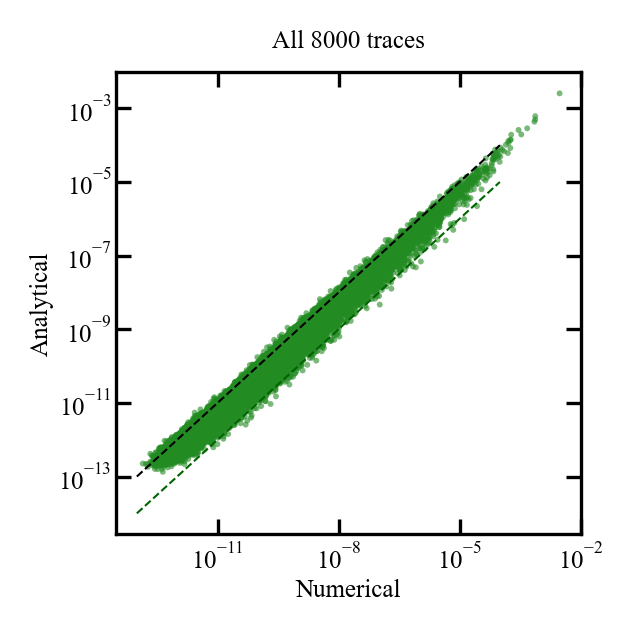

In [118]:
fig, ax1 = plt.subplots(1, figsize=(2, 2), dpi=300)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.scatter(psd_fit_data_all[:, -2], psd_fit_data_all[:, -1], edgecolor='None', alpha=0.6, s=2, c='forestgreen')
ax1.plot(np.logspace(-13, -4, base=10), np.logspace(-13, -4, base=10), ls='--', c='k', lw=0.5)
ax1.plot(np.logspace(-13, -4, base=10), np.logspace(-13, -4, base=10)/10, ls='--', c='darkgreen', lw=0.5)

ax1.set_xlabel('Numerical')
ax1.set_ylabel('Analytical')

ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')

ax1.set_title('All 8000 traces', fontsize=6)

Text(0.5, 1.0, 'All 8000 traces')

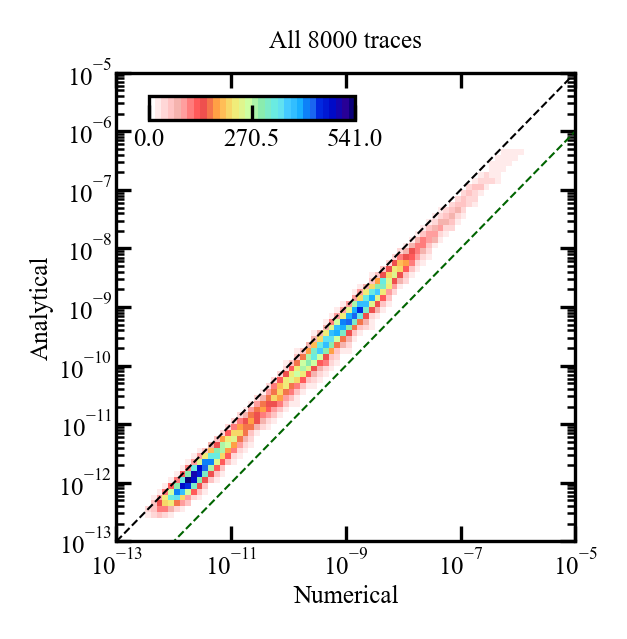

In [119]:
x_mesh, y_mesh, area_hist_all = utils.calc_hist_2d_single(x=psd_fit_data_all[:, -2], y=psd_fit_data_all[:, -1],
                                                        xrange=(1e-13, 1e-5), log_scale_x=True,
                                                        yrange=(1e-13, 1e-5), log_scale_y=True,
                                                        num_bins=(10, 10),
                                                        bin_mode_x='decade',
                                                        bin_mode_y='decade')

fig, ax1 = plt.subplots(1, figsize=(2, 2), dpi=300)

fig.tight_layout()
ax1.set_xscale('log')
ax1.set_yscale('log')
# ax1.scatter(psd_fit_data_all[:, -2], psd_fit_data_all[:, -1], edgecolor='None', alpha=0.6, s=2, c='cornflowerblue')
im1 = ax1.pcolormesh(x_mesh, y_mesh, area_hist_all, cmap=utils.cmap_geo32)
ax1.plot(np.logspace(-13, -5, base=10), np.logspace(-13, -5, base=10), ls='--', c='k', lw=0.5)
ax1.plot(np.logspace(-13, -5, base=10), np.logspace(-13, -5, base=10)/10, ls='--', c='darkgreen', lw=0.5)
cbaxes_all = ax1.inset_axes([0.07, 0.9, 0.45, 0.05])
plt.colorbar(im1, cax=cbaxes_all, ticks=np.linspace(0, max(area_hist_all.flatten()), 3), orientation='horizontal')

ax1.set_xlabel('Numerical')
ax1.set_ylabel('Analytical')

ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')

ax1.set_title('All 8000 traces', fontsize=6)

Text(0.5, 1.0, 'All 8000 traces')

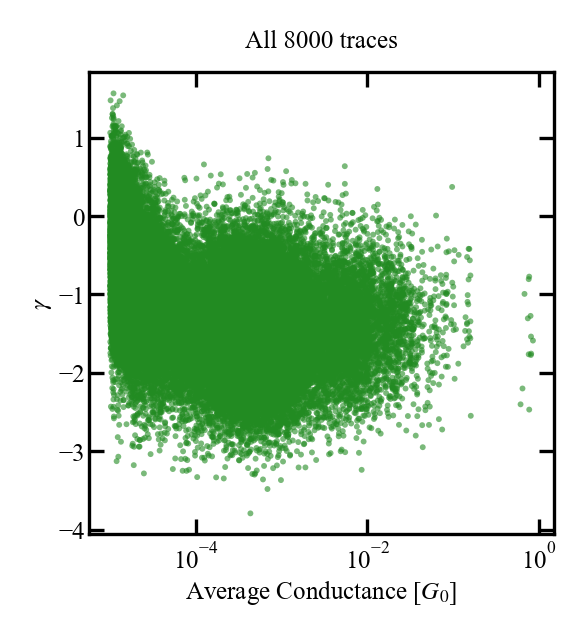

In [122]:
fig, ax1 = plt.subplots(ncols=1, figsize=(2, 2), dpi=300)
ax1.set_xscale('log')
# ax1.set_yscale('log')
ax1.scatter(psd_fit_data_all[:, 0], psd_fit_data_all[:, 1], edgecolor='None', alpha=0.6, s=2, c='forestgreen')

ax1.set_xlabel(r'Average Conductance [$G_{0}$]')
ax1.set_ylabel(r'$\gamma$')

ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')

ax1.set_title('All 8000 traces', fontsize=6)

Text(0.5, 1.0, 'All 8000 traces')

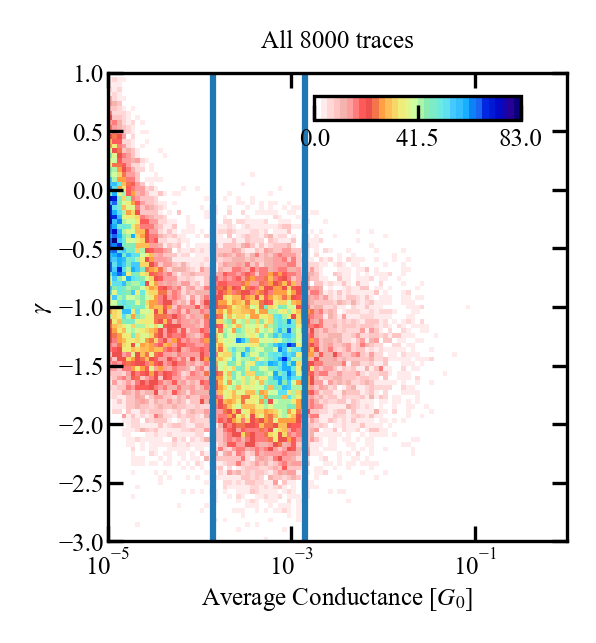

In [137]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

x_mesh, y_mesh, area_hist_all = utils.calc_hist_2d_single(x=psd_fit_data_all[:, 0], y=psd_fit_data_all[:, 1],
                                                        xrange=(1e-5, 1), log_scale_x=True,
                                                        yrange=(-3, 1), log_scale_y=False,
                                                        num_bins=(20, 100),
                                                        bin_mode_x='decade')

fig, ax1 = plt.subplots(1, figsize=(2, 2), dpi=300)

fig.tight_layout()
ax1.set_xscale('log')
# ax1.set_yscale('log')
# ax1.scatter(psd_fit_data_all[:, -2], psd_fit_data_all[:, -1], edgecolor='None', alpha=0.6, s=2, c='cornflowerblue')
im1 = ax1.pcolormesh(x_mesh, y_mesh, area_hist_all, cmap=utils.cmap_geo32)
# ax1.plot(np.logspace(-5, 0, base=10), np.logspace(-5, 0, base=10), ls='--', c='k', lw=0.5)
# ax1.plot(np.logspace(-5, -0, base=10), np.logspace(-5, 0, base=10)/10, ls='--', c='blue', lw=0.5)
cbaxes_all = ax1.inset_axes([0.45, 0.9, 0.45, 0.05])
plt.colorbar(im1, cax=cbaxes_all, ticks=np.linspace(0, max(area_hist_all.flatten()), 3), orientation='horizontal')

ax1.set_xlabel(r'Average Conductance [$G_0$]')
ax1.set_ylabel(r'$\gamma$')

ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.axvline(x_mesh[0][23])
ax1.axvline(x_mesh[0][43])
ax1.set_title('All 8000 traces', fontsize=6)

In [141]:
psds_in_bins_all = {}

for which_trace in tqdm(range(len(cond_avg_all))):
    for i, ind in enumerate(np.where(cond_avg_all[which_trace] > 1e-5)[0]):
        bin_low_lim = np.where(x_mesh[0] < cond_avg_all[which_trace][ind])[0][-1]  # bin_high_lim = bin_low_lim + 1
        if bin_low_lim in psds_in_bins_all.keys():
            psds_in_bins_all[bin_low_lim].append(psd_results_all[which_trace][ind, :])
        else:
            psds_in_bins_all[bin_low_lim] = [psd_results_all[which_trace][ind, :]]

  0%|          | 0/8000 [00:00<?, ?it/s]

In [142]:
mean_psds_in_bins_all = {}

for psd_key in psds_in_bins_all.keys():
    psds_in_bins_all[psd_key] = np.array(psds_in_bins_all[psd_key])
    mean_psds_in_bins_all[psd_key] = np.mean(psds_in_bins_all[psd_key], axis=0)
    # print(list(map(lambda x: x.shape, psds_in_bins[psd_key])))

In [143]:
sorted_keys_all = np.array(list(psds_in_bins_all.keys()))
sorted_keys_all.sort()
sorted_keys_all[np.bitwise_and(sorted_keys_all>=23, sorted_keys_all<43)]

array([23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41, 42], dtype=int64)

In [144]:
# sorted_keys_1

In [145]:
# mean_psds_in_bins_1

In [147]:
gamma_mean_all = []
cond_val_all = []
for i, mean_key in enumerate(sorted_keys_all):
    # (gamma, logbeta), (dgamma, dlogbeta) = fit_psd(fft_freqs_all, mean_psds_in_bins_all[mean_key], freq_range=(1000, 10000))
    # gamma_mean_all.append([gamma, dgamma])
    cond_val_all.append((x_mesh[0][mean_key] + x_mesh[0][mean_key+1])/2)
    
    (gamma, logbeta), (dgamma, dlogbeta) = fit_psd(fft_freqs, mean_psds_in_bins_all[mean_key]/cond_val_all[-1], freq_range=(1000, 10000))
    gamma_mean_all.append([gamma, dgamma])
    
gamma_mean_all = np.array(gamma_mean_all)

Text(0.5, 0, 'Frequency [Hz]')

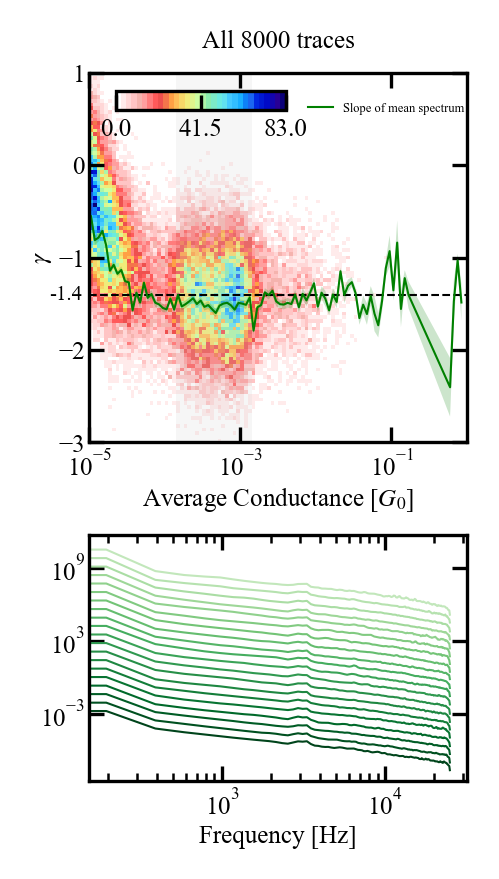

In [158]:
x_mesh, y_mesh, gamma_hist_all = utils.calc_hist_2d_single(x=psd_fit_data_all[:, 0], y=psd_fit_data_all[:, 1],
                                                        xrange=(1e-5, 1e0), log_scale_x=True,
                                                        yrange=(-3, 1), log_scale_y=False,
                                                        num_bins=(20, 100),
                                                        bin_mode_x='decade')

# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(4, 2), dpi=300)
fig = plt.figure(figsize=utils.cm2inch(4, 7.5), dpi=300)
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=(3, 2),
                       figure=fig, left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])

ax3 = fig.add_subplot(gs[1, 0])

ax1.set_xscale('log')
# ax1.scatter(psd_fit_data_all[:, -2], psd_fit_data_all[:, -1], edgecolor='None', alpha=0.6, s=2, c='cornflowerblue')
im1 = ax1.pcolormesh(x_mesh, y_mesh, gamma_hist_all, cmap=utils.cmap_geo32)
cbaxes_all = ax1.inset_axes([0.07, 0.9, 0.45, 0.05])
plt.colorbar(im1, cax=cbaxes_all, ticks=np.linspace(0, max(gamma_hist_all.flatten()), 3), orientation='horizontal')

ax1.set_xlabel(r'Average Conductance [$G_{0}$]')
ax1.set_ylabel(r'$\gamma$')

ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')

ax1.set_title('All 8000 traces', fontsize=6)

ax1.axvspan(x_mesh[0, 23], x_mesh[0, 43], alpha=0.2, edgecolor=None, facecolor='lightgrey')

ax1.axhline(-1.4, ls='--', c='k', lw=0.5)
ax1.text(x=3e-6, y=-1.4, s='-1.4', fontsize=5, verticalalignment='center')

ax3.yaxis.set_ticks_position('both')
ax3.xaxis.set_ticks_position('both')

ax3.set_xscale('log')
ax3.set_yscale('log')

my_blues = colormaps['Blues'](np.linspace(0, 1, 27)[::-1])
my_reds = colormaps['Reds'](np.linspace(0, 1, 27)[::-1])
my_greens = colormaps['Greens'](np.linspace(0, 1, 27)[::-1])

ax1.plot(cond_val_all, gamma_mean_all[:,0], lw=0.5, color='green', label='Slope of mean spectrum')
ax1.fill_between(cond_val_all, gamma_mean_all[:,0]-gamma_mean_all[:,1], gamma_mean_all[:,0]+gamma_mean_all[:,1], lw=0.5, alpha=0.2, color='green', edgecolor=None)

ax1.legend(fontsize=3, bbox_to_anchor=(0.55, 0.95), frameon=False)

for i, mean_key in enumerate(sorted_keys_all[np.bitwise_and(sorted_keys_all>=23, sorted_keys_all<43)]):
    # ax3.plot(fft_freqs_all, mean_psds_in_bins_all[mean_key], c=my_blues[i], lw=0.5)
    ax3.plot(fft_freqs, mean_psds_in_bins_all[mean_key]/((x_mesh[0][mean_key]+x_mesh[0][mean_key+1])/2)**2 * 5**i, c=my_greens[i], lw=0.5)
    
ax3.set_xlabel(r'Frequency [Hz]')
# ax3.set_ylabel(r'$S_{I}\;[\mathrm{A}^2/\mathrm{Hz}]$')

# plt.savefig(home_folder.joinpath('results/article/mean_psds_and_slopes_data.png'), bbox_inches='tight')

In [160]:
# np.savetxt(home_folder.joinpath('results/article/slope_2d_hist_8000.txt'), gamma_hist_all)
# np.savetxt(home_folder.joinpath('results/article/mean_spectra_8000.txt'),
#            np.hstack([mean_psds_in_bins_all[i].reshape((-1, 1)) for i in sorted_keys_all]),
#            header=' '.join(sorted_keys_all.astype(str)))